# Imports

In [1]:
import numpy as np
import pandas as pd
np.random.seed(20030403)

In [2]:
np.random.seed(20030403)

# Activator Functions

In [3]:
def linear(x):
    """ Liniowa funkcja aktywacji """
    return  x

def sigmoidal(x):
    """ sigmoidalna funkcja aktywacji """
    return 1/(1 + np.exp(-x))

print(linear(3))
print(sigmoidal(0))

3
0.5


Działają jak należy :)

# MLP no backprop

In [4]:
class MLPNoBackprop:
    def __init__(self, layers, weights, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='linear'):
        self.layers = layers
        self.weights = weights        
        self.biases = [np.zeros((n,)) for n in layers[1:]]
        activation_functions = {"linear": linear, "sigmoid": sigmoidal}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)

    def forward(self, X):
        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation_function(z)
            activations.append(activation)
        z = activation @ self.weights[-1] + self.biases[-1]
        output = self.output_activation_function(z)
        activations.append(output)
        return activations

    def predict(self, X):
        return self.forward(X)[-1].flatten()
    
    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)


# Szkolenie dla square-simple


Moja idea szkolenie - losuje wagi i biasy dla kazdej warstwy i porownuje z najlepszym wynikiem do tej pory, jesli lepszy to zamieniam, jesli nie to szukam dalej. 

## Helper Functions

In [5]:
def drop_first_column(df): # przydatne przy wczytywaniu danych
    df.drop(df.columns[[0]], axis=1, inplace=True)

def random_weights(layers): # aby szybko losowac wagi
    return [np.random.randn(layers[i], layers[i+1]) for i in range(len(layers)-1)]

def random_biases(layers): # -||- biasy
    return [np.random.randn(n) for n in layers[1:]]

## Szkolenie - square simple

In [6]:
train_data_path = "../regression/square-simple-training.csv"
test_data_path = "../regression/square-simple-test.csv"
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
drop_first_column(train_data) # usuwam pierwsza kolumne, bo tam sa numery wierszy - niepotrzbne
drop_first_column(test_data)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [7]:
train_data.shape

(100, 2)

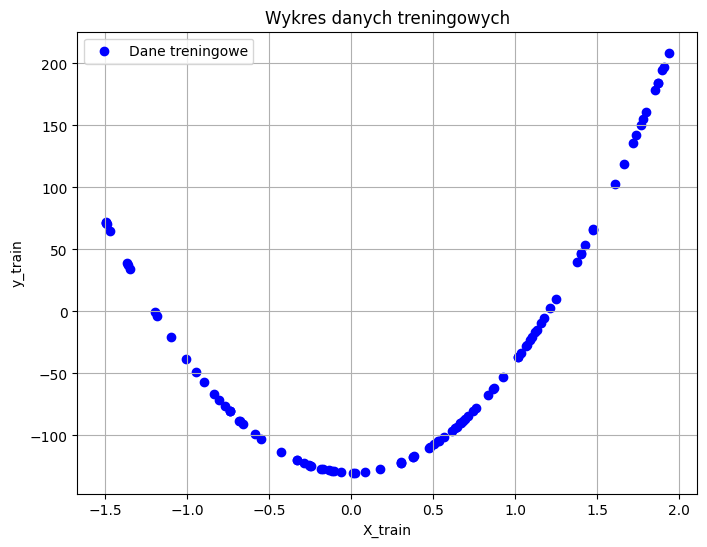

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Dane treningowe')
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.title("Wykres danych treningowych")
plt.legend()
plt.grid()
plt.show()

Dane wyglądają poprawnie

In [9]:
input_dim = X_train.shape[1]
variants = [ # rozpratrze 3 mozliwosci - tak jak w leonie
    [input_dim, 5, 1],       
    [input_dim, 10, 1],
    [input_dim, 5, 5, 1]
]

In [10]:
num_iterations = 10000


best_weights_list = []
best_biases_list = []
mse_res = []

for i in range(len(variants)):
    layers = variants[i]
    mlp = MLPNoBackprop(layers, random_weights(layers))
    best_mse = float('inf')
    best_weights = None
    best_biases = None

    for j in range(num_iterations):
        weights = random_weights(layers)
        biases = random_biases(layers)
        
        for m in range(len(weights)):
            mlp.set_weights_and_biases(m, weights[m], biases[m])
        
        y_pred = mlp.predict(X_train)
        mse = mlp.mse(y_train, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_weights = weights
            best_biases = biases

    for j in range(len(best_weights)):
        mlp.set_weights_and_biases(j, best_weights[j], best_biases[j])

    y_test_pred = mlp.predict(X_test)
    test_mse = mlp.mse(y_test, y_test_pred)

    print("Najlepszy MSE na zbiorze treningowym:", best_mse)
    print("MSE na zbiorze testowym:", test_mse)
    best_weights_list.append(best_weights)
    best_biases_list.append(best_biases)
    mse_res.append(test_mse)

print(mse_res)


Najlepszy MSE na zbiorze treningowym: 9665.286486387466
MSE na zbiorze testowym: 8164.478826804216
Najlepszy MSE na zbiorze treningowym: 9584.837847005827
MSE na zbiorze testowym: 8029.021823927161
Najlepszy MSE na zbiorze treningowym: 9781.279476434527
MSE na zbiorze testowym: 8282.736457377856
[np.float64(8164.478826804216), np.float64(8029.021823927161), np.float64(8282.736457377856)]


Najlepszy wynik jest dla [1, 10, 1] o wagach:

In [11]:
best_weights_list[1]

[array([[-1.42070099,  0.05823013,  0.83308292, -0.46104966, -1.27358041,
         -0.84077081,  0.53027607,  0.17931212, -0.15749933,  1.24781605]]),
 array([[ 0.32258451],
        [-2.0451704 ],
        [ 0.04319965],
        [-2.96117717],
        [-2.05785833],
        [-1.68693128],
        [-0.34615815],
        [-3.11311134],
        [-1.02052291],
        [-0.87522061]])]

i biasach

In [12]:
best_biases_list[1]

[array([ 1.45718805,  0.37886454,  0.0693731 ,  1.81779402, -0.6235552 ,
         0.17891967, -0.02668248,  1.10188527,  0.15183457,  2.1756914 ]),
 array([-0.34275031])]

# Szkolenie dla steps large

In [28]:
train_data_path = "../regression/steps-small-training.csv"
test_data_path = "../regression/steps-small-test.csv"
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
drop_first_column(train_data) # usuwam pierwsza kolumne, bo tam sa numery wierszy - niepotrzbne
drop_first_column(test_data)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50, 1)
(50,)
(50, 1)
(50,)


Wykres:

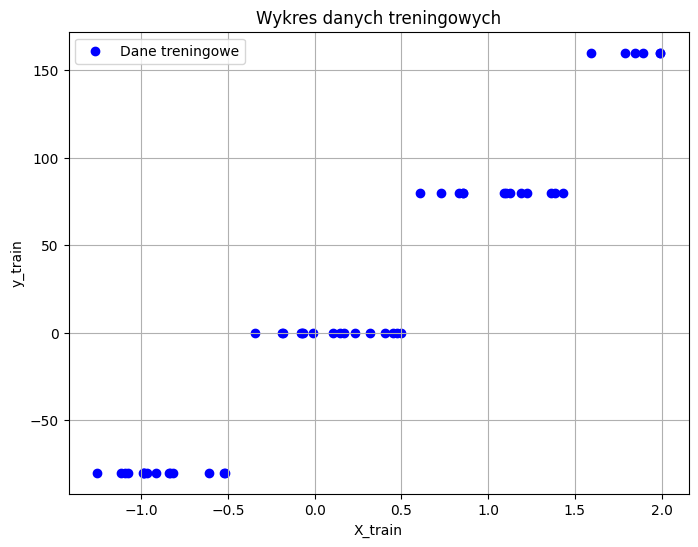

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Dane treningowe')
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.title("Wykres danych treningowych")
plt.legend()
plt.grid()
plt.show()


Na wykresie widac schody, sprobuje dobrac wagi tak, aby każdemu "schodkowi" przypasować neuron

In [16]:
layers = [1, 5, 1]  

W_hidden = np.array([[40,40,40,40,40]])
b_hidden = np.array([ 80, 20 ,  -20,  -60,  -80 ])

W_output = np.array([[0.0],
                     [80.0],
                     [80.0],
                     [ 80.0],
                     [ 0.0]])
b_output = np.array([-80.0])

mlp = MLPNoBackprop(
    layers=layers, 
    weights=[W_hidden, W_output],
    hidden_activation_function='sigmoid',
    output_activation_function='linear'
)

mlp.set_weights_and_biases(0, W_hidden, b_hidden)
mlp.set_weights_and_biases(1, W_output, b_output)


In [17]:
y_test_pred = mlp.predict(X_test)
test_mse = mlp.mse(y_test, y_test_pred.flatten())

print("MSE na zbiorze testowym:", test_mse)

MSE na zbiorze testowym: 7.225500591019597


MSE mniejsze od 9, zatem ok ;)

zobaczmy jak wyglądają na wykresie

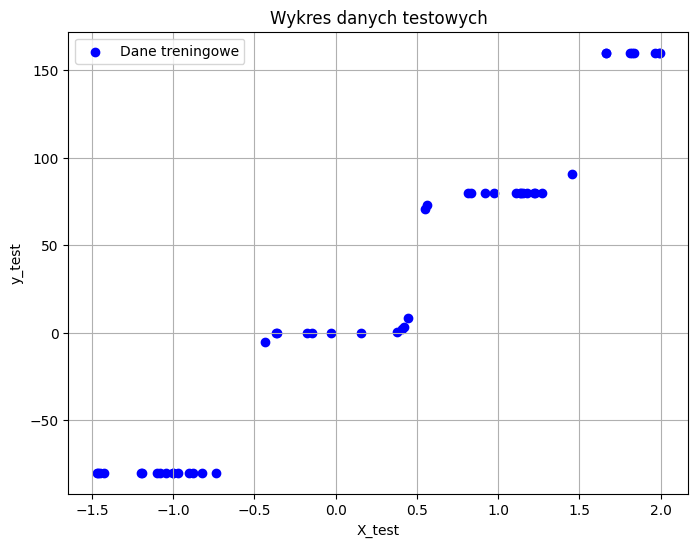

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test_pred, color='blue', label='Dane treningowe')
plt.xlabel("X_test")
plt.ylabel("y_test")
plt.title("Wykres danych testowych")
plt.legend()
plt.grid()
plt.show()


Wygląda dobrze :)